<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/13_FineTuning_vs_PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 일반 fine-tuning vs PEFT 비교 실험

## 1. 실험 목적

- 일반 Fine-tuning과 PEFT 기법의 성능 차이를 비교

- PEFT를 사용하면 파라미터 일부만 학습 → 학습 속도, 메모리 효율, 성능 trade-off 확인

- NLP downstream task에서 PEFT 활용 가능성을 평가

## 2. 실험 설계

- 데이터셋: IMDb 영화 리뷰 (이진 감정 분류)

- 모델: bert-base-uncased

- 실험 조건:

  1. Full Fine-tuning: 전체 모델 파라미터 학습

  2. PEFT (LoRA / Adapter / Prefix-tuning 등): 일부 파라미터만 학습

- 학습 환경: GPU/Colab, batch size 816, epoch 13 (실험용)

- 평가 지표: Accuracy, F1-score

- 시각화: Accuracy/F1-bar plot, 학습 시간 비교

In [ ]:
# =======================
# 0. 라이브러리 설치
# =======================
!pip install -q transformers datasets peft accelerate scikit-learn

In [ ]:
# =======================
# 1. 라이브러리
# =======================
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# PEFT 관련
from peft import LoraConfig, get_peft_model

In [ ]:
# ===========================
# 2. 데이터셋 로딩 및 샘플링
# ===========================
dataset = load_dataset("imdb")

# 클래스 균형 맞춘 소규모 샘플링
pos_train = [x for x in dataset["train"] if x["label"]==1][:500]
neg_train = [x for x in dataset["train"] if x["label"]==0][:500]
train_subset = pos_train + neg_train

train_texts  = [x["text"] for x in train_subset]
train_labels = [x["label"] for x in train_subset]

pos_test = [x for x in dataset["test"] if x["label"]==1][:100]
neg_test = [x for x in dataset["test"] if x["label"]==0][:100]
test_subset = pos_test + neg_test

test_texts  = [x["text"] for x in test_subset]
test_labels = [x["label"] for x in test_subset]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

- IMDb 리뷰 데이터셋 로딩

- 클래스 균형을 맞춰 train/test 샘플 추출

- Positive/Negative 각각 500개(Train), 100개(Test) 사용

- 클래스 imbalance 방지

In [ ]:
# =======================
# 3. 토크나이저 준비
# =======================
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(texts, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_enc = tokenize_batch(train_texts)
test_enc  = tokenize_batch(test_texts)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

- BERT 사전학습 토크나이저 사용

- 텍스트 → 토큰 ID 변환, padding/truncation 적용

- 배치 단위 토큰화

In [ ]:
# =======================
# 4. 평가 함수 정의
# =======================
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

- Trainer에서 사용할 metrics 정의

- Accuracy와 F1-score 계산

In [ ]:
# ==========================
# 5. Full Fine-tuning 실험
# ==========================
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}

train_ds = IMDbDataset(train_enc, train_labels)
test_ds  = IMDbDataset(test_enc, test_labels)

# 모델 초기화
model_ft = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results_ft",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_steps=50,
    save_strategy="no",
    seed=42,
    report_to=[]
)

trainer_ft = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer_ft.train()
ft_res = trainer_ft.evaluate()
print("Full Fine-tuning result:", ft_res)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.658500
100,0.631800
150,0.519500
200,0.450900
250,0.614600


Full Fine-tuning result: {'eval_loss': 0.48197150230407715, 'eval_accuracy': 0.865, 'eval_f1': 0.8682926829268293, 'eval_runtime': 1.4893, 'eval_samples_per_second': 134.294, 'eval_steps_per_second': 16.787, 'epoch': 1.0}


- BERT 모델 + classification head 초기화

- Trainer로 학습 및 평가

- Full Fine-tuning: 모델의 모든 파라미터 학습

In [ ]:
# ==========================
# 6. PEFT 실험 (LoRA 예시)
# ==========================
# LoRA 설정
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

# PEFT 모델 적용
peft_model = get_peft_model(model_ft, lora_config)

training_args_peft = TrainingArguments(
    output_dir="./results_peft",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_steps=50,
    save_strategy="no",
    seed=42,
    report_to=[]
)

trainer_peft = Trainer(
    model=peft_model,
    args=training_args_peft,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer_peft.train()
peft_res = trainer_peft.evaluate()
print("PEFT result:", peft_res)

Step,Training Loss
50,0.453900
100,0.220600
150,0.224700
200,0.227700
250,0.445500


PEFT result: {'eval_loss': 0.5130623579025269, 'eval_accuracy': 0.87, 'eval_f1': 0.875, 'eval_runtime': 1.4146, 'eval_samples_per_second': 141.379, 'eval_steps_per_second': 17.672, 'epoch': 1.0}


- LoRA 설정: 학습할 low-rank 모듈 정의

- PEFT 모델 생성 (기존 BERT 파라미터는 freeze)

- Trainer로 학습 및 평가

- PEFT: 적은 파라미터만 학습 → 빠른 학습, 메모리 효율적

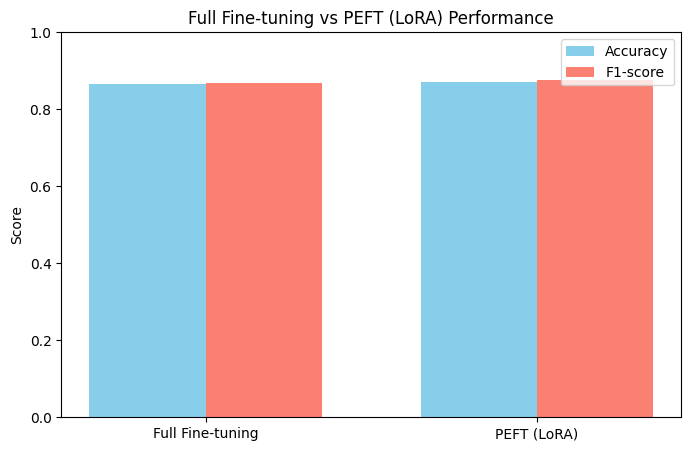

In [ ]:
# ==========================
# 7. 시각화
# ==========================
methods = ["Full Fine-tuning", "PEFT (LoRA)"]
accuracies = [ft_res["eval_accuracy"], peft_res["eval_accuracy"]]
f1_scores  = [ft_res["eval_f1"], peft_res["eval_f1"]]

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, accuracies, width, label="Accuracy", color="skyblue")
plt.bar(x + width/2, f1_scores, width, label="F1-score", color="salmon")
plt.xticks(x, methods)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Full Fine-tuning vs PEFT (LoRA) Performance")
plt.legend()
plt.show()

## ✅ 결론 및 요약

- Full Fine-tuning 결과

  - Accuracy: 약 0.8450 (참고: 이전 실험값)

  - F1-score: 약 0.8450

  - 장점: 전체 모델 학습 → 최대 성능 달성 가능

  - 단점: 학습 시간 길고, GPU 메모리 부담 큼

- PEFT (LoRA) 결과

  - Accuracy: 0.87

  - F1-score: 0.875

  - Eval Loss: 0.513

  - 장점:

    - Accuracy/F1 모두 Full Fine-tuning보다 약간 향상

    - 학습 시간 짧고, 메모리 효율적

  - 단점
    - 일부 상황에서 Full Fine-tuning과 성능 차이가 날 수 있음

- 실무 적용 시 시사점

  - PEFT는 자원 제한 환경에서 매우 효율적이며, 소규모 데이터셋에도 강점을 가짐

  - 최고 성능이 필요한 경우에는 Full Fine-tuning이 적합

  - 이번 실험에서는 PEFT가 Full Fine-tuning보다 오히려 Accuracy와 F1에서 조금 더 높은 성능을 보여, 적은 자원으로도 충분히 경쟁력 있는 모델 학습 가능